# ANN assisted TPS on capped alanine dipeptide 2
In this notebook you will learn
- how to perform input importance analyses for models with transformed atomistic coordinates, i.e. how to find which are the important ANN inputs and how to relate them to atomistic coordinates
- how to create visualizizations of the transitions colored by gradient

This notebook uses files created in `1_setup_and_TPS.ipynb`, please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths

Using TensorFlow backend.


In [3]:
# change to the working directory of choice
# same as for the first notebook
wdir = '/homeloc/scratch/hejung/arcd_scratch/ala/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

In [4]:
storage = paths.Storage('ala_HB_TPS.nc', 'a')

In [5]:
# get the sampler, attach the hook and run for 1 step to repopulate the trainset and load the model
sampler = storage.pathsimulators[0]
sampler.restart_at_step(storage.steps[-1], storage=storage)

trainhook = arcd.ops.TrainingHook(None, None, 100)
sampler.attach_hook(trainhook)

sampler.run(1)

Working on Monte Carlo cycle number 1001
Starting simulation...
Working on first step


/homeloc/scratch/hejung/conda-envs/arcd/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


DONE! Completed 1001 Monte Carlo cycles.


## HIPR analysis
We will have a look at the most important inputs and which atoms contribute to them.

In [30]:
hipr = arcd.analysis.HIPRanalysis(trainhook.model, trainhook.trainset)

In [63]:
final_hipr_losses = hipr.do_hipr(5)

In [47]:
# lets load the model after 100 MCsteps to compare
from arcd.base.rcmodel import RCModel
fname = storage.abspath + '_RCmodel_at_step100.pckl'
state, cls = RCModel.load_state(fname, storage)
state = cls.fix_state(state)
model_at_step100 = cls.set_state(state)

In [48]:
# use the complete trainset for HIPR
# this includes point the ANN has never trained on but makes it comparable to the previous HIPR
hipr_at_step100 = arcd.analysis.HIPRanalysis(model_at_step100, trainhook.trainset)

In [64]:
step100_hipr_losses = hipr_at_step100.do_hipr(5)

Reference loss:  1.2892837524414062
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  1.3013421865609975
coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  1.2908536135495365
coordinate:  ('cos', [4, 6, 8, 14])
with associated loss:  1.2906466473589888
coordinate:  [0, 1, 4]
with associated loss:  1.29054905513188
coordinate:  [16, 18, 20]
with associated loss:  1.2903741750802908


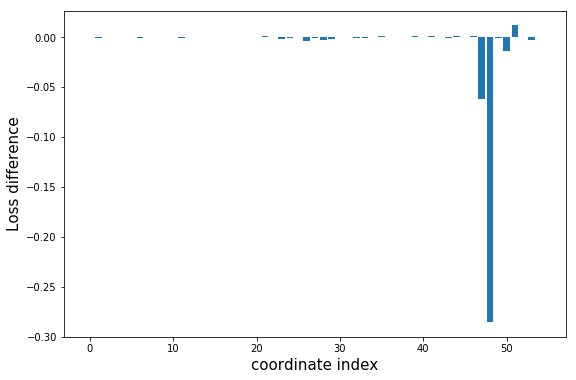

In [69]:
final_loss_diff = final_hipr_losses[:-1] - final_hipr_losses[-1]
step100_loss_diff = step100_hipr_losses[:-1] - step100_hipr_losses[-1]

plt.bar(np.arange(len(final_loss_diff)), final_loss_diff)
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

# get the associated coordinates for the maximaly important input
max_idx = np.argsort(final_loss_diff)[::-1]

# this bit below only works for IC only
# figuring out how to get the info for SF CVs is left as an excersise to the reader :)
ic_parms = trainhook.model.descriptor_transform.kwargs['ic_parms']


print('Reference loss: ', final_hipr_losses[-1])
for idx in max_idx[:5]:
    # this little helper function gets you the involved atoms given the input index and the inputparameters to the CV of question
    # there is similar functions for the symmetry functions @ arcd.coords.symmetry.get_involved
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', final_hipr_losses[idx])

Reference loss:  0.6980597679907983
coordinate:  ('sin', [14, 16, 18, 19])
with associated loss:  0.6982101486160325
coordinate:  ('cos', [14, 16, 18, 19])
with associated loss:  0.698183066933067
coordinate:  ('cos', [0, 1, 4, 5])
with associated loss:  0.6981611284223589
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  0.6981297312916576
coordinate:  ('sin', [0, 1, 4, 5])
with associated loss:  0.6981232466873946


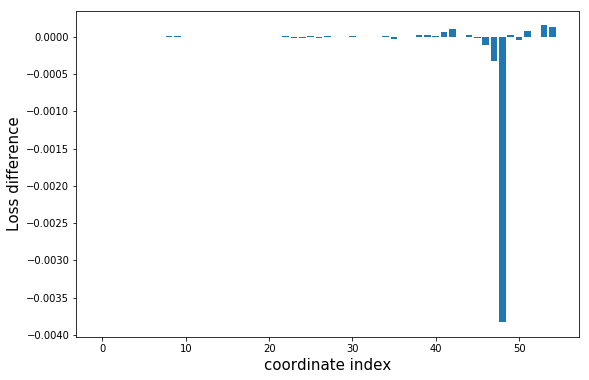

In [70]:
plt.bar(np.arange(len(step100_loss_diff)), step100_loss_diff, label='after step 100')
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

max_idx = np.argsort(step100_loss_diff)[::-1]
print('Reference loss: ', step100_hipr_losses[-1])
for idx in max_idx[:5]:
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', step100_hipr_losses[idx])

## Now we know that the dihedral between atoms 14, 16, 18 and 19 seems to be quite important....so what are these atoms?

In [54]:
# lets get a snapshot from trajectory, such that we can ask its topology object for the atom names
snap = storage.snapshots[-1]
topol = snap.topology.mdtraj

In [68]:
for at in [6, 8, 14, 16, 18, 19]:
    print('atom: ', topol.atom(at), ' with index: ', at)

atom:  ALA2-N  with index:  6
atom:  ALA2-CA  with index:  8
atom:  ALA2-C  with index:  14
atom:  NME3-N  with index:  16
atom:  NME3-C  with index:  18
atom:  NME3-H1  with index:  19


In [57]:
model_at_step100.test_loss(trainhook.trainset)

0.6980597679907983